In [2]:
import torch
from time import time
import warnings
import numpy as np
import torch.nn as nn

from torch.utils.data import DataLoader
from datasets.cityscapes import CityScapes
from tqdm import tqdm
from PIL import Image
from fvcore.nn import FlopCountAnalysis, flop_count_table

from models.deeplabv2.deeplabv2 import get_deeplab_v2
from utils import fast_hist, per_class_iou

warnings.filterwarnings("ignore")

### Training - Single Channel

In [3]:
def train():
    # Set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cpu')
    # Load the model
    model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)

    # Load the dataset
    dataset = CityScapes(root_dir='datasets/Cityspaces', split='val', mode='single', raw_label=False)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

    criterion = nn.CrossEntropyLoss(ignore_index=255)
    # optimizer = optim.Adam(model.parameters(), lr=0.0001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.007, momentum=0.9, weight_decay=0.0005)
    # Set the model to training mode
    model.train()
    # Train the model using tqdm
    for epoch in range(10):
        hist = np.zeros((19, 19))
        for image, label in tqdm(dataloader):
            image = image.to(device)
            label = label.to(device)
            # Forward pass
            output = model(image)[0]
            # output shape: (1, 19, 128, 256)
            # label shape: (1, 128, 256)
            # Calculate the loss
            loss = criterion(output, label)
            # Zero the gradients
            optimizer.zero_grad()
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()

            # Compute the predictions (1, 128, 256)
            pred = output.argmax(dim=1)

            # Calculate the mean IoU
            hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
            miou = np.mean(per_class_iou(hist))

        print(f'Epoch: {epoch}, Loss: {loss.item()}, mIoU: {miou}')

    # Save the model
    torch.save(model.state_dict(), 'models/deeplabv2/deeplabv2.pth')

train()    

Deeplab pretraining loading...


  0%|          | 0/63 [00:07<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 264.00 MiB. GPU 

### Validation

In [3]:
def validate():
    # Set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Load the model
    model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)
    model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
    model.eval()

    # Load the dataset
    dataset = CityScapes(root_dir='datasets/Cityspaces', split='val', mode='single', raw_label=False)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

    hist = np.zeros((19, 19))
    for i, (image, label) in tqdm(enumerate(dataloader)):
        image = image.to(device)
        label = label.to(device)
        # Forward pass
        output = model(image)
        # output shape: (1, 19, 128, 256)
        # label shape: (1, 128, 256)
        # Compute the predictions (1, 128, 256)
        pred = output.argmax(dim=1)


        # Calculate the mean IoU
        hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
        miou = np.mean(per_class_iou(hist))

    print(f'mIoU: {miou}')
    
validate()

Deeplab pretraining loading...


32it [00:18,  1.72it/s]

mIoU: 0.4283237915004


### Example

Deeplab pretraining loading...


0it [00:01, ?it/s]


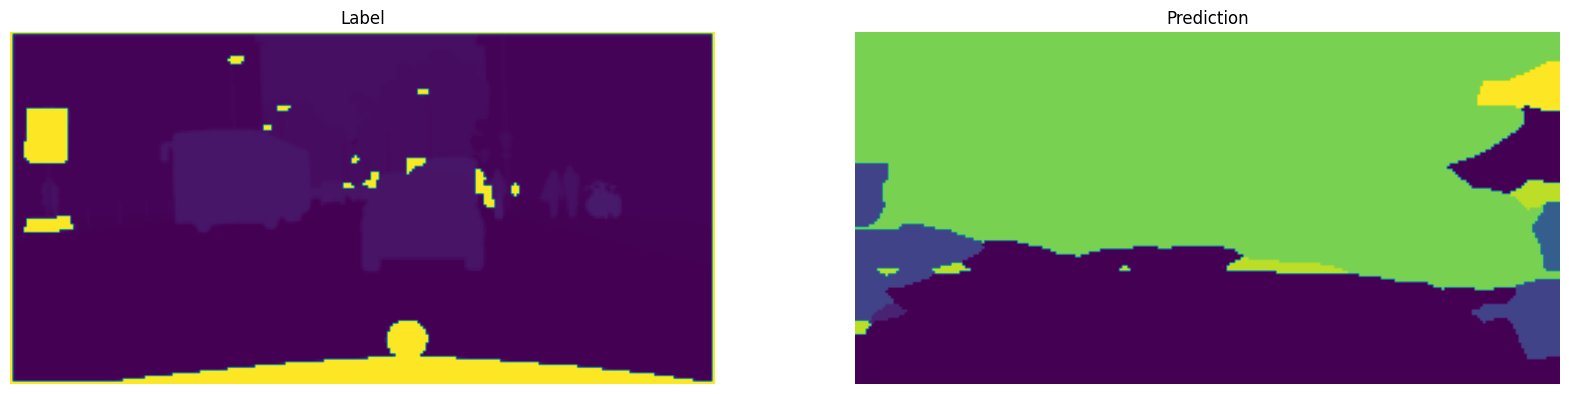

In [3]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val', mode='single', raw_label=False)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

hist = np.zeros((19, 19))
for i, (image, label) in tqdm(enumerate(dataloader)):
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # output shape: (1, 19, 128, 256)
    # label shape: (1, 128, 256)
    # Compute the predictions (1, 128, 256)
    pred = output.argmax(dim=1)
    break

# Display the image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

image = ToPILImage()(image[0].cpu())
# Convert label, pred from numpy to image
label = Image.fromarray(label[0].cpu().numpy().astype(np.uint8))
pred = Image.fromarray(pred[0].cpu().numpy().astype(np.uint8))

plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.subplot(122)
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')
plt.show()

### FLOPs and Parameters

In [21]:
# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2')
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val', mode='single', raw_label=False)

# Get the image and label
image, label = dataset[0]

# Compute the number of flops
flops = FlopCountAnalysis(model, image.unsqueeze(0))
# Get the number of flops
flops = flop_count_table(flops)

# Get the number of parameters
params = sum(p.numel() for p in model.parameters())

print(f'Number of parameters: {params}\n')
print(flops)

Deeplab pretraining loading...
Number of parameters: 43901068

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 43.901M                | 25.046G    |
|  conv1                         |  9.408K                |  77.07M    |
|   conv1.weight                 |   (64, 3, 7, 7)        |            |
|  bn1                           |  0.128K                |  1.049M    |
|   bn1.weight                   |   (64,)                |            |
|   bn1.bias                     |   (64,)                |            |
|  layer1                        |  0.216M                |  0.463G    |
|   layer1.0                     |   75.008K              |   0.161G   |
|    layer1.0.conv1              |    4.096K              |    8.786M  |
|    layer1.0.bn1                |    0.128K              |    0.275M  |
|    layer1.0.conv2              |    36.864K             |  

### Latency and FPS

In [12]:
# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2')
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2.pth'))
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val', mode='single', label_raw=False)


# Get the image and label
image, label = dataset[0]

# Compute the latency and FPS
iterations = 1000
latency = []
fps = []

for _ in range(iterations):
    start = time()
    model(image.unsqueeze(0))
    end = time()
    latency.append(end - start)
    fps.append(1 / (end - start))

# Compute the average latency and FPS
mean_latency = np.mean(latency)
mean_fps = np.mean(fps)
std_latency = np.std(latency)
std_fps = np.std(fps)

print(f'Latency: {mean_latency:.3f} +/- {std_latency:.3f}')
print(f'FPS: {mean_fps:.3f} +/- {std_fps:.3f}')


Deeplab pretraining loading...
Latency: 0.063 +/- 0.002
FPS: 15.855 +/- 0.341
